In [1]:
# %pip install open3d -q
# %pip install numpy-stl -q
# %pip install timm -q

In [7]:
import os
import zipfile
from glob import glob

import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import cv2
import open3d as o3d
from skimage.measure import marching_cubes
from PIL import Image
from stl import mesh

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from matplotlib.colors import LightSource
import seaborn as sns

import timm
from tqdm import tqdm
import glob

plt.style.use('default')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
base_path = '/home/jupyter/datasphere/project/iTMO'

archive_file = os.path.join(base_path, 'dataset.zip')
extract_dir = os.path.join(base_path, 'extracted_data') 

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(archive_file, 'r') as zf:
    zf.extractall(path=extract_dir)

print(f"Архив распакован в '{extract_dir}'")

Архив распакован в '/home/jupyter/datasphere/project/iTMO/extracted_data'


In [10]:
extract_dir = os.path.join('/home/jupyter/datasphere/project/iTMO', 'extracted_data', 'dataset')

all_png = glob.glob(os.path.join(extract_dir, '**', '*.png'), recursive=True)
all_stl = glob.glob(os.path.join(extract_dir, '**', '*.stl'), recursive=True)

png_bases = {os.path.splitext(os.path.basename(p))[0] for p in all_png}
stl_bases = {os.path.splitext(os.path.basename(s))[0] for s in all_stl}

common_bases = sorted(list(png_bases.intersection(stl_bases)))

paired_png_paths = [os.path.join(extract_dir, f"{base}.png") for base in common_bases]
paired_stl_paths = [os.path.join(extract_dir, f"{base}.stl") for base in common_bases]

print(f"Найдено {len(common_bases)} пар")


Найдено 561 пар


In [11]:
class VoxelDataset(Dataset):
    def __init__(self, png_paths, stl_paths, grid_size=64, image_size=(256, 256), augment=False):
        self.png_paths = png_paths
        self.stl_paths = stl_paths
        self.grid_size = grid_size
        self.image_height = image_size[0]
        self.image_width = image_size[1]
        self.augment = augment

        self.image_transforms = transforms.Compose([
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.GaussianBlur(kernel_size=3),
            ], p=0.7 if augment else 0),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.png_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.png_paths[idx], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (self.image_width, self.image_height))
        image = torch.from_numpy(image.astype(np.float32) / 255.0).unsqueeze(0)
        
        if self.augment:
            image = self.image_transforms(image)

        # Загрузка и обработка меша
        mesh = o3d.io.read_triangle_mesh(self.stl_paths[idx])
        if mesh.has_vertices():
            bbox = mesh.get_axis_aligned_bounding_box()
            mesh.translate(-bbox.get_center())
            mesh.scale(1.0 / np.max(bbox.get_extent()), center=np.zeros(3))

        # Вокселизация
        voxels = self._mesh_to_voxels(mesh)
        return image, voxels, idx

    def _mesh_to_voxels(self, mesh):
        if not mesh.has_triangles():
            return torch.zeros((self.grid_size, self.grid_size, self.grid_size))

        voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(
            mesh, 
            voxel_size=2.0 / self.grid_size
        )

        voxels = np.zeros((self.grid_size, self.grid_size, self.grid_size))
        for voxel in voxel_grid.get_voxels():
            i, j, k = voxel.grid_index
            if 0 <= i < self.grid_size and 0 <= j < self.grid_size and 0 <= k < self.grid_size:
                voxels[i, j, k] = 1.0

        return torch.from_numpy(voxels).float()

In [12]:
trainval_png, test_png, trainval_stl, test_stl = train_test_split(
    paired_png_paths,
    paired_stl_paths,
    test_size=0.2,
    random_state=42
)

train_png, val_png, train_stl, val_stl = train_test_split(
    trainval_png,
    trainval_stl,
    test_size=0.25,
    random_state=42
)

print(f"Train: {len(train_png)}, Val: {len(val_png)}, Test: {len(test_png)}")

Train: 336, Val: 112, Test: 113


In [14]:
GRID_SIZE = 32
BATCH_SIZE = 32

train_dataset = VoxelDataset(
    train_png, 
    train_stl, 
    grid_size=GRID_SIZE,
    augment=True
)

val_dataset = VoxelDataset(
    val_png, 
    val_stl, 
    grid_size=GRID_SIZE,
    augment=False
)

test_dataset = VoxelDataset(
    test_png, 
    test_stl, 
    grid_size=GRID_SIZE,
    augment=False
)

# Даталоадеры
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

In [ ]:
class EnhancedEncoder(nn.Module):
    def __init__(self, model_name='swinv2_tiny_window16_256.ms_in1k', pretrained=True,
                 out_indices=(0, 1, 2, 3), return_skips=True,
                 projected_main_channels=1024,
                 skip_projection_channels=(64, 128, 256)):
        super().__init__()
        self.return_skips = return_skips

        if self.return_skips:
            if len(out_indices) < 2:
                raise ValueError("out_indices должен содержать >= 2 индексов.")
            if len(skip_projection_channels) != (len(out_indices) - 1):
                raise ValueError(f"Длина skip_projection_channels не соответствует количеству skip-уровней.")
            self.actual_out_indices = out_indices
        else:
            self.actual_out_indices = (out_indices[-1],)

        self.backbone = timm.create_model(
            model_name, pretrained=pretrained, features_only=True, out_indices=self.actual_out_indices
        )
        feature_info_list = self.backbone.feature_info

        self.num_main_features_in = feature_info_list[-1]['num_chs']
        self.proj_main = nn.Conv2d(self.num_main_features_in, projected_main_channels, kernel_size=1)

        if self.return_skips:
            self.skip_projs = nn.ModuleList()
            skip_feature_info_list = feature_info_list[:-1]
            for i in range(len(skip_feature_info_list)):
                self.skip_projs.append(
                    nn.Conv2d(skip_feature_info_list[i]['num_chs'], skip_projection_channels[i], kernel_size=1)
                )

    def _to_bchw(self, feature_map, num_expected_channels):
        if feature_map.dim() == 4:
            if feature_map.shape[1] != num_expected_channels and feature_map.shape[3] == num_expected_channels:
                return feature_map.permute(0, 3, 1, 2)
            elif feature_map.shape[1] == num_expected_channels:
                return feature_map
        raise ValueError(f"Неожиданная форма карты признаков: {feature_map.shape} или кол-во каналов ({num_expected_channels} ожидалось).")


    def forward(self, x):
        if x.size(1) == 1: x = x.expand(-1, 3, -1, -1)
        features_list_raw = self.backbone(x)
        if not isinstance(features_list_raw, (list, tuple)): features_list_raw = [features_list_raw]

        main_features_raw = features_list_raw[-1]
        main_features_bchw = self._to_bchw(main_features_raw, self.num_main_features_in)
        main_features_projected = self.proj_main(main_features_bchw)

        if self.return_skips:
            processed_skip_features = []
            raw_skips = features_list_raw[:-1]
            for i, skip_raw in enumerate(raw_skips):
                expected_skip_channels = self.backbone.feature_info[i]['num_chs']
                skip_bchw = self._to_bchw(skip_raw, expected_skip_channels)
                skip_projected = self.skip_projs[i](skip_bchw)
                processed_skip_features.append(skip_projected)
            return main_features_projected, processed_skip_features
        else:
            return main_features_projected

In [16]:
# Тест для skip-connection
encoder = EnhancedEncoder(return_skips=True)
dummy_input = torch.randn(1, 1, 256, 256)
features, skips = encoder(dummy_input)
print("\nMain features shape:", features.shape)
for i, skip in enumerate(skips):
    print(f"Skip {i} shape:", skip.shape)


Main features shape: torch.Size([1, 1024, 8, 8])
Skip 0 shape: torch.Size([1, 64, 64, 64])
Skip 1 shape: torch.Size([1, 128, 32, 32])
Skip 2 shape: torch.Size([1, 256, 16, 16])


In [ ]:
print("Анализ распределения классов в train_dataset")
total_voxels = 0
positive_voxels = 0


for i in tqdm(range(len(train_dataset)), desc="Checking dataset samples"):
    _, voxel_target, _ = train_dataset[i]
    
    positive_voxels += voxel_target.sum().item()
    total_voxels += voxel_target.numel()

if total_voxels > 0:
    positive_ratio_dataset = positive_voxels / total_voxels
    print(f"\nАнализ всего train_dataset:")
    print(f"  Общее количество вокселей: {total_voxels}")
    print(f"  Количество положительных вокселей (объектов): {positive_voxels}")
    print(f"  Доля положительных вокселей (Positive ratio): {positive_ratio_dataset:.6f}")
else:
    print("Датасет пуст или не удалось обработать.")


Анализ распределения классов в train_dataset...


Checking dataset samples: 100%|██████████| 336/336 [00:15<00:00, 21.18it/s]


Анализ всего train_dataset:
  Общее количество вокселей: 11010048
  Количество положительных вокселей (объектов): 283329.0
  Доля положительных вокселей (Positive ratio): 0.025734


In [ ]:
class VoxelDecoder(nn.Module):
    def __init__(self, grid_size=32, in_encoder_channels=1024,
                 start_3d_channels=256, start_3d_depth=4,
                 skip_channels_from_encoder=None,
                 decoder_skip_proj_channels=(32, 64, 128),
                 dropout_p_decoder=0.1
                 ):
        super().__init__()
        self.grid_size = grid_size
        self.start_3d_depth = start_3d_depth
        self.start_3d_channels = start_3d_channels
        self.use_skips = skip_channels_from_encoder is not None

        self.prepare_3d = nn.Sequential(
            nn.Conv2d(in_encoder_channels, self.start_3d_channels * self.start_3d_depth,
                      kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.start_3d_channels * self.start_3d_depth),
            nn.ReLU(inplace=True)
        )

        up_block_out_channels = [128, 64, 32]
        main_flow_in_channels = [self.start_3d_channels] + up_block_out_channels[:-1]

        self.up_blocks = nn.ModuleList()
        if self.use_skips:
            if len(skip_channels_from_encoder) != len(up_block_out_channels) or \
               len(decoder_skip_proj_channels) != len(up_block_out_channels):
                raise ValueError("Размеры списков каналов для skip-соединений не совпадают с количеством up_blocks.")
            
            self.skip_projs_decoder = nn.ModuleList()

            _skip_channels_from_encoder_rev = skip_channels_from_encoder[::-1]
            _decoder_skip_proj_channels_rev = decoder_skip_proj_channels[::-1]

            for i in range(len(up_block_out_channels)):
                self.skip_projs_decoder.append(
                    nn.Conv2d(_skip_channels_from_encoder_rev[i], _decoder_skip_proj_channels_rev[i], kernel_size=1)
                )
                # Входной канал для ResidualUpsampleBlock = основной поток + спроецированный skip
                block_in_ch = main_flow_in_channels[i] + _decoder_skip_proj_channels_rev[i]
                self.up_blocks.append(ResidualUpsampleBlock(block_in_ch, up_block_out_channels[i], dropout_p_decoder))
        else:
            for i in range(len(up_block_out_channels)):
                self.up_blocks.append(ResidualUpsampleBlock(main_flow_in_channels[i], up_block_out_channels[i], dropout_p_decoder))

        self.final_conv = nn.Sequential(
            nn.Conv3d(up_block_out_channels[-1], 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.Conv3d(16, 1, kernel_size=1)
        )

    def _interpolate_and_repeat_skip(self, skip_2d_projected, target_3d_shape_bchwd):
        B, _, D_target, H_target, W_target = target_3d_shape_bchwd
        
        # Интерполируем H, W skip-фичи
        skip_2d_resized = F.interpolate(skip_2d_projected, size=(H_target, W_target), mode='bilinear', align_corners=False)
        # Раздуваем до 3D
        skip_3d = skip_2d_resized.unsqueeze(2).repeat(1, 1, D_target, 1, 1)
        return skip_3d

    def forward(self, x_main, skip_features_list=None):
        x = self.prepare_3d(x_main)
        B, C_prep, H_prep, W_prep = x.shape
        x = x.view(B, self.start_3d_channels, self.start_3d_depth, H_prep, W_prep)

        current_main_flow = x
        if self.use_skips and skip_features_list is not None:
            _skip_features_list_rev = skip_features_list[::-1]

            for i in range(len(self.up_blocks)):
                skip_2d_raw = _skip_features_list_rev[i]
                skip_2d_projected_in_decoder = self.skip_projs_decoder[i](skip_2d_raw)
                
                skip_3d_aligned = self._interpolate_and_repeat_skip(
                    skip_2d_projected_in_decoder,
                    current_main_flow.shape
                )
                
                concatenated_input = torch.cat((current_main_flow, skip_3d_aligned), dim=1)
                current_main_flow = self.up_blocks[i](concatenated_input)
        else:
            for block in self.up_blocks:
                current_main_flow = block(current_main_flow)
        
        output_logits = self.final_conv(current_main_flow)
        return output_logits


class ResidualUpsampleBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose3d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout3d(dropout_p),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(out_ch)
        )
        self.shortcut = nn.ConvTranspose3d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False)
        self.alpha = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        return F.relu(self.alpha * self.conv(x) + (1 - self.alpha) * self.shortcut(x), inplace=True)

In [ ]:
class AdvancedVoxelNet(nn.Module):
    def __init__(self, grid_size=32, use_skip_connections=True,
                 encoder_model_name='swinv2_tiny_window16_256.ms_in1k',
                 encoder_pretrained=True,
                 encoder_out_indices=(0, 1, 2, 3),
                 encoder_projected_main_channels=1024,
                 encoder_skip_projection_channels=(64, 128, 256),
                 decoder_start_3d_channels=256,
                 decoder_start_3d_depth=4,
                 decoder_projection_channels_for_skips=(32, 64, 128),
                 decoder_dropout_p=0.1
                 ):
        super().__init__()
        self.grid_size = grid_size
        self.use_skip_connections = use_skip_connections

        self.encoder = EnhancedEncoder(
            model_name=encoder_model_name, pretrained=encoder_pretrained,
            out_indices=encoder_out_indices, return_skips=self.use_skip_connections,
            projected_main_channels=encoder_projected_main_channels,
            skip_projection_channels=list(encoder_skip_projection_channels) if self.use_skip_connections else []
        )

        self.decoder = VoxelDecoder(
            grid_size=grid_size,
            in_encoder_channels=encoder_projected_main_channels,
            start_3d_channels=decoder_start_3d_channels,
            start_3d_depth=decoder_start_3d_depth,
            skip_channels_from_encoder=list(encoder_skip_projection_channels) if self.use_skip_connections else None,
            decoder_skip_proj_channels=list(decoder_projection_channels_for_skips) if self.use_skip_connections else None,
            dropout_p_decoder=decoder_dropout_p
        )

    def forward(self, x):
        if self.use_skip_connections:
            main_features, skip_features_list = self.encoder(x)
            output_logits = self.decoder(main_features, skip_features_list)
        else:
            main_features = self.encoder(x)
            output_logits = self.decoder(main_features, skip_features_list=None)
        return output_logits

In [20]:
def iou(pred, target, threshold=0.5, smooth=1e-6):
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    target_bin = (target > threshold).float()
    
    intersection = (pred_bin * target_bin).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target_bin.sum(dim=(1,2,3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [ ]:
class ComboLoss(nn.Module):
    def __init__(self, weight_dice=0.5, focal_gamma=2.0, 
                 focal_alpha_balancing=None,
                 smooth_dice=1e-6):
        super().__init__()
        self.weight_dice = weight_dice
        self.weight_focal = 1.0 - weight_dice
        self.focal_gamma = focal_gamma
        self.focal_alpha_balancing = focal_alpha_balancing
        self.smooth_dice = smooth_dice

    def _dice_loss_from_logits(self, logits, targets_binary_float):
        probs = torch.sigmoid(logits)
        if probs.dim() > 2:
            probs_flat = probs.view(probs.size(0), -1)
            targets_flat = targets_binary_float.view(targets_binary_float.size(0), -1)
        else:
            probs_flat = probs
            targets_flat = targets_binary_float
            
        intersection = (probs_flat * targets_flat).sum(dim=1)
        denominator = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)
        dice_score_per_sample = (2. * intersection + self.smooth_dice) / (denominator + self.smooth_dice)
        return 1. - dice_score_per_sample

    def _focal_loss_from_logits(self, logits, targets_binary_float):
        bce_loss_elements = F.binary_cross_entropy_with_logits(
            logits, targets_binary_float, reduction='none' 
        )
        probs = torch.sigmoid(logits)
        p_t = probs * targets_binary_float + (1 - probs) * (1 - targets_binary_float)
        
        focal_modulator = (1 - p_t) ** self.focal_gamma
        
        loss_elements = focal_modulator * bce_loss_elements

        if self.focal_alpha_balancing is not None:
            alpha_t = self.focal_alpha_balancing * targets_binary_float + \
                      (1 - self.focal_alpha_balancing) * (1 - targets_binary_float)
            loss_elements = alpha_t * loss_elements
        
        return loss_elements.mean()

    def forward(self, pred_logits, targets):
        targets_float = targets.float()

        dice_loss_val = self._dice_loss_from_logits(pred_logits, targets_float).mean() 
        focal_loss_val = self._focal_loss_from_logits(pred_logits, targets_float)
        
        combined_loss = self.weight_dice * dice_loss_val + self.weight_focal * focal_loss_val
        return combined_loss

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AdvancedVoxelNet(
    grid_size=32, 
    use_skip_connections=True
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=0.01
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.5,
    patience=3, 
    verbose=True,
    min_lr=1e-7
)

criterion = ComboLoss(
    weight_dice=0.5,
    focal_gamma=2.0,
    focal_alpha_balancing=0.25 
).to(device)

In [28]:
# Инициализация весов
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv3d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.decoder.apply(init_weights)

VoxelDecoder(
  (prepare_3d): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (up_blocks): ModuleList(
    (0): ResidualUpsampleBlock(
      (conv): Sequential(
        (0): ConvTranspose3d(384, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout3d(p=0.1, inplace=False)
        (4): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (5): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): ConvTranspose3d(384, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    )
    (1): ResidualUpsampleBlock(
      (conv): Seque

In [29]:
def fit_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0
    
    for images, voxels, _ in train_loader:
        images = images.to(device)
        targets = voxels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        total_iou += iou(outputs, targets) * batch_size
        total_samples += batch_size
    
    return total_loss / total_samples, total_iou / total_samples

def val_epoch(model, criterion, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for images, voxels, _ in val_loader:
            images = images.to(device)
            targets = voxels.to(device).unsqueeze(1)
            
            outputs = model(images)
            total_loss += criterion(outputs, targets).item() * images.size(0)
            total_iou += iou(outputs, targets) * images.size(0)
            total_samples += images.size(0)
    
    return total_loss / total_samples, total_iou / total_samples

Начинаем обучение...


Обучение:   7%|▋         | 1/15 [00:34<08:06, 34.75s/it]


Epoch 1/15:
  Train: Loss 0.5747 | IoU 0.0328
  Val:   Loss 0.5033 | IoU 0.0218
  LR: 1.00e-03


Обучение:  13%|█▎        | 2/15 [01:09<07:30, 34.65s/it]


Epoch 2/15:
  Train: Loss 0.4649 | IoU 0.0986
  Val:   Loss 0.4540 | IoU 0.0517
  LR: 1.00e-03


Обучение:  20%|██        | 3/15 [01:43<06:54, 34.57s/it]


Epoch 3/15:
  Train: Loss 0.4486 | IoU 0.1342
  Val:   Loss 0.4491 | IoU 0.1207
  LR: 1.00e-03


Обучение:  27%|██▋       | 4/15 [02:17<06:18, 34.42s/it]


Epoch 4/15:
  Train: Loss 0.4100 | IoU 0.3937
  Val:   Loss 0.3988 | IoU 0.3991
  LR: 1.00e-03


Обучение:  33%|███▎      | 5/15 [02:52<05:44, 34.41s/it]


Epoch 5/15:
  Train: Loss 0.3771 | IoU 0.5581
  Val:   Loss 0.3923 | IoU 0.6255
  LR: 1.00e-03


Обучение:  40%|████      | 6/15 [03:26<05:09, 34.39s/it]


Epoch 6/15:
  Train: Loss 0.3626 | IoU 0.5910
  Val:   Loss 0.3783 | IoU 0.6356
  LR: 1.00e-03


Обучение:  47%|████▋     | 7/15 [03:48<04:02, 30.28s/it]


Epoch 7/15:
  Train: Loss 0.3540 | IoU 0.6112
  Val:   Loss 0.3719 | IoU 0.6194
  LR: 1.00e-03


Обучение:  53%|█████▎    | 8/15 [04:22<03:41, 31.58s/it]


Epoch 8/15:
  Train: Loss 0.3496 | IoU 0.6102
  Val:   Loss 0.3945 | IoU 0.6442
  LR: 1.00e-03


Обучение:  60%|██████    | 9/15 [04:57<03:14, 32.46s/it]


Epoch 9/15:
  Train: Loss 0.3424 | IoU 0.6165
  Val:   Loss 0.3910 | IoU 0.6483
  LR: 1.00e-03


Обучение:  67%|██████▋   | 10/15 [05:19<02:25, 29.19s/it]


Epoch 10/15:
  Train: Loss 0.3391 | IoU 0.6253
  Val:   Loss 0.3678 | IoU 0.6218
  LR: 1.00e-03


Обучение:  73%|███████▎  | 11/15 [05:40<01:47, 26.88s/it]


Epoch 11/15:
  Train: Loss 0.3326 | IoU 0.6149
  Val:   Loss 0.3856 | IoU 0.6465
  LR: 1.00e-03


Обучение:  80%|████████  | 12/15 [06:02<01:15, 25.28s/it]


Epoch 12/15:
  Train: Loss 0.3260 | IoU 0.6223
  Val:   Loss 0.3884 | IoU 0.6396
  LR: 1.00e-03


Обучение:  87%|████████▋ | 13/15 [06:23<00:48, 24.11s/it]


Epoch 13/15:
  Train: Loss 0.3231 | IoU 0.6382
  Val:   Loss 0.4194 | IoU 0.6353
  LR: 1.00e-03


Обучение:  93%|█████████▎| 14/15 [06:45<00:23, 23.29s/it]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.

Epoch 14/15:
  Train: Loss 0.3137 | IoU 0.6420
  Val:   Loss 0.3927 | IoU 0.6437
  LR: 5.00e-04


Обучение: 100%|██████████| 15/15 [07:06<00:00, 28.44s/it]


Epoch 15/15:
  Train: Loss 0.3005 | IoU 0.6574
  Val:   Loss 0.4046 | IoU 0.6413
  LR: 5.00e-04


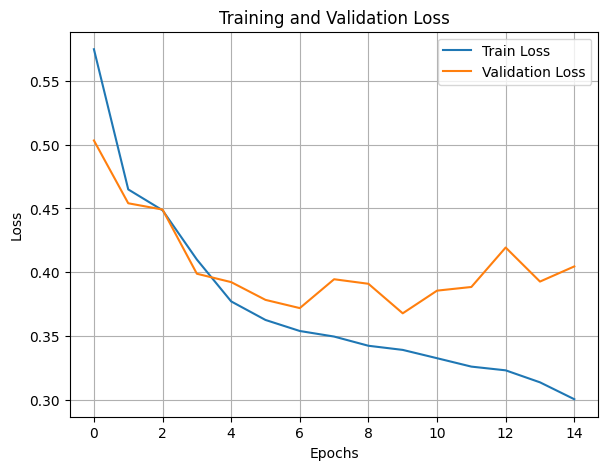

In [30]:
epochs = 15
patience = 15
best_val_iou = 0.0
no_improve = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'train_iou': [],
    'val_iou': [],
    'lr': []
}


print("Начинаем обучение...")
best_iou = 0.0

for epoch in tqdm(range(epochs), desc="Обучение"):
    model.train()
    train_loss, train_iou = fit_epoch(model, criterion, optimizer, train_loader, device)
    
    model.eval()
    val_loss, val_iou = val_epoch(model, criterion, val_loader, device)
        
    scheduler.step(val_loss)
    
    if val_iou > best_iou + 0.001:
        best_iou = val_iou
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve += 1
        
    if no_improve >= patience:
        print(f"Early stopping (Best IoU: {best_iou:.4f})")
        break

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"  Train: Loss {train_loss:.4f} | IoU {train_iou:.4f}")
    print(f"  Val:   Loss {val_loss:.4f} | IoU {val_iou:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")

def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

plot_training_history(history)

In [ ]:
def save_3d_prediction(voxels, output_dir, sample_id, threshold=None):
    """Сохраняет предсказанные воксели как 3D модель с автоматическим определением порога"""
    os.makedirs(output_dir, exist_ok=True)
    
    if threshold is None:
        threshold = np.percentile(voxels, 95)
        print(f"Выбранный threshold: {threshold:.3f}")
    
    vmin, vmax = voxels.min(), voxels.max()
    if threshold < vmin or threshold > vmax:
        threshold = (vmin + vmax) / 2  # Среднее значение если порог вне диапазона
        print(f" threshold изменен {threshold:.3f} (range:  {vmin:.3f}-{vmax:.3f})")
    
    try:
        vertices, faces, _, _ = marching_cubes(voxels, level=threshold)
        mesh = o3d.geometry.TriangleMesh()
        mesh.vertices = o3d.utility.Vector3dVector(vertices)
        mesh.triangles = o3d.utility.Vector3iVector(faces)
        
        mesh.compute_vertex_normals()
        mesh = mesh.filter_smooth_taubin(number_of_iterations=5)
        
        ply_path = os.path.join(output_dir, f"pred_{sample_id}.ply")
        o3d.io.write_triangle_mesh(ply_path, mesh)
        print(f"Saved 3D prediction to {ply_path}")
        
    except Exception as e:
        print(f"Failed to create 3D model for sample {sample_id}: {str(e)}")
        np.save(os.path.join(output_dir, f"raw_voxels_{sample_id}.npy"), voxels)

In [32]:
def visualize_predictions(model, val_loader, num_samples=5, output_dir="predictions", device=None):
    """Визуализация и сохранение предсказаний модели с улучшенной обработкой"""
    print("\n--- Визуализация результатов модели ---")
    
    if device is None:
        device = next(model.parameters()).device
    
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    
    visualized_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Processing samples"):
            if visualized_samples >= num_samples:
                break
                
            images = batch[0].to(device)
            pred_voxels = model(images).squeeze(1).cpu().numpy()
            
            for i in range(len(images)):
                sample_id = visualized_samples + 1
                img = images[i].squeeze().cpu().numpy()
                pred = pred_voxels[i]
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
                
                ax1.imshow(img, cmap='gray')
                ax1.set_title(f"Input Image {sample_id}")
                ax1.axis('off')
                
                mid_slice = pred.shape[0] // 2
                im = ax2.imshow(pred[mid_slice], cmap='viridis')
                ax2.set_title(f"Prediction Slice (min: {pred.min():.2f}, max: {pred.max():.2f})")
                fig.colorbar(im, ax=ax2)
                ax2.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                save_3d_prediction(pred, output_dir, sample_id)
                
                visualized_samples += 1
                if visualized_samples >= num_samples:
                    break
    
    print(f"\nВизуализация завершена. Сохранено {visualized_samples} примеров в {output_dir}")


--- Визуализация результатов модели ---


Processing samples:   0%|          | 0/4 [00:00<?, ?it/s]

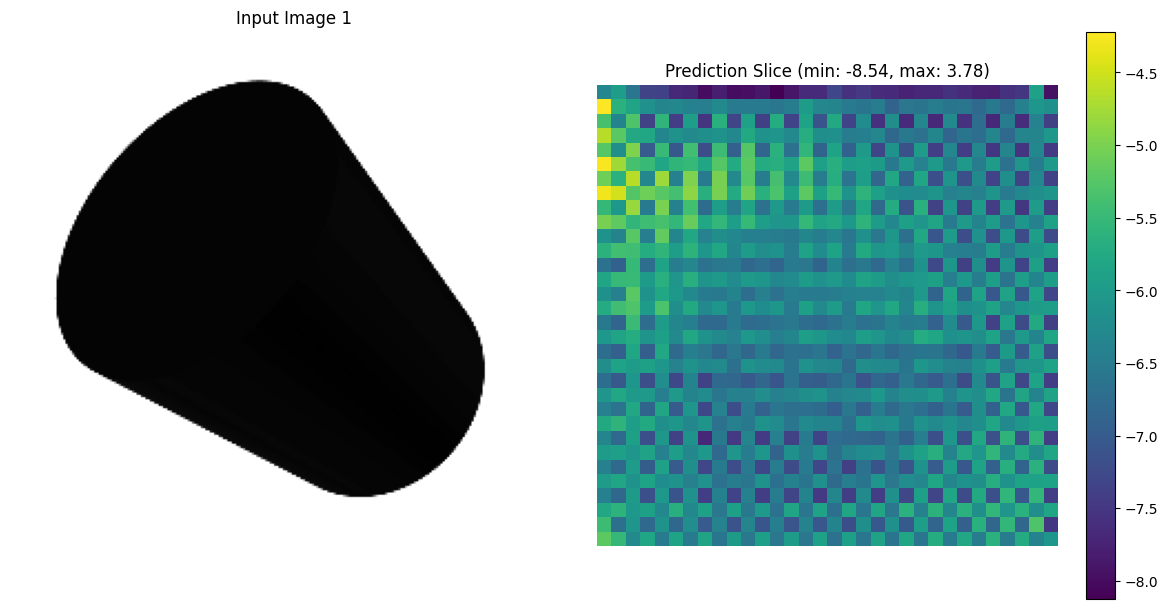

Auto-selected threshold: -5.059
Saved 3D prediction to predictions/pred_1.ply


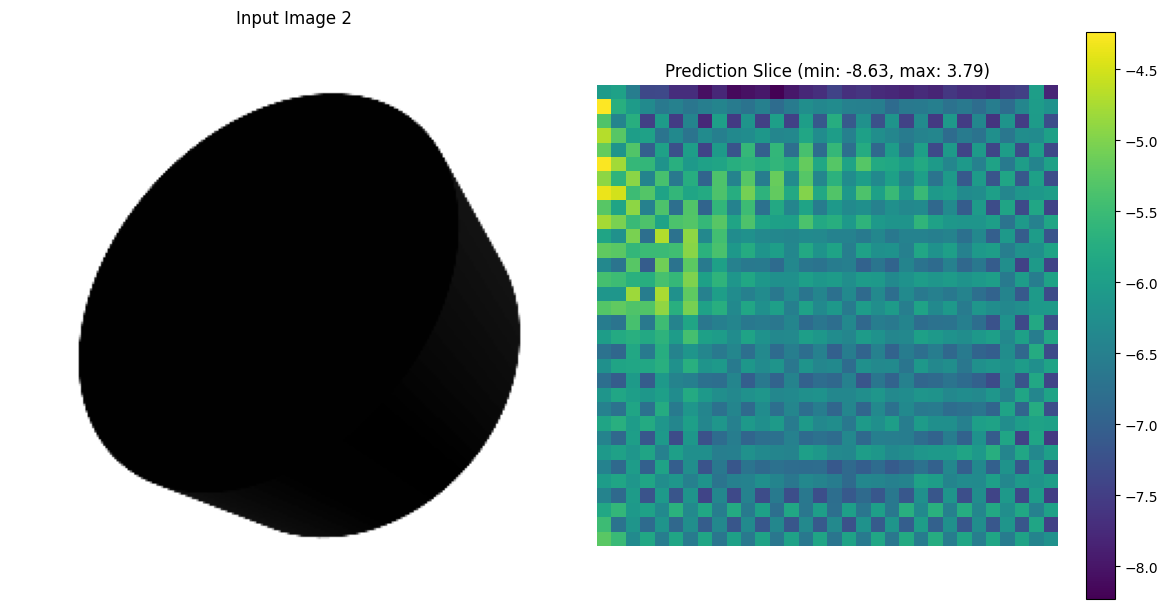

Auto-selected threshold: -4.921
Saved 3D prediction to predictions/pred_2.ply


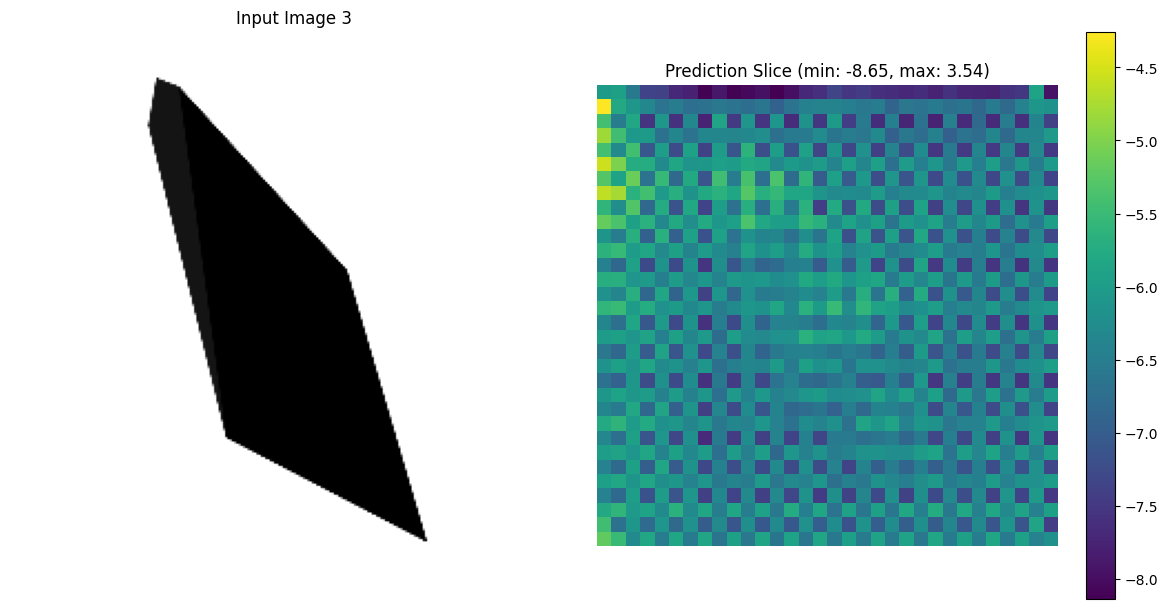

Processing samples:  25%|██▌       | 1/4 [00:02<00:08,  2.92s/it]

Auto-selected threshold: -5.311
Saved 3D prediction to predictions/pred_3.ply


Processing samples:  25%|██▌       | 1/4 [00:03<00:11,  3.95s/it]


Визуализация завершена. Сохранено 3 примеров в predictions


In [33]:
visualize_predictions(
    model=model,
    val_loader=val_loader,
    num_samples=3,
    output_dir="predictions",
    device="cuda"
)